# Visual Genome Dataset Investigation

In [1]:
import json
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from transformers.tokenization_bert import BasicTokenizer
import nltk
import torch
from pycocotools.coco import COCO

In [3]:
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.modeling.language_backbone.transformers import BERT

In [4]:
ann_file = '../datasets/coco/annotations/captions_train2017.json'
with open(ann_file, 'r') as fin:
    coco_train_anno_all = json.load(fin)

In [5]:
len(coco_train_anno_all['annotations'])

591753

In [6]:
print(coco_train_anno_all['annotations'][0])

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [7]:
count=1
id=coco_train_anno_all['annotations'][0]['image_id']
for item in coco_train_anno_all['annotations'][1:]:
    if item['image_id'] == id:
        count += 1
print(count)

5


In [8]:
tokenizer = BasicTokenizer(do_lower_case=True)

In [9]:
nltk.pos_tag(tokenizer.tokenize("He takes a banana."))

[('he', 'PRP'), ('takes', 'VBZ'), ('a', 'DT'), ('banana', 'NN'), ('.', '.')]

# Getting Stats

In [11]:
# Counts number of examples for each noun 
# for those sentences having number of noun types each of {0,1,2,..max_noun_no,'Rest'}

def per_tp_no_distr_stats(max_noun_no, tp):
    
    noun_distr_per_noun_no = {}
    ex_count_per_noun_no = {}
    img_caps_per_noun_no = {}
    
    for i in range(1,max_noun_no+1):
        noun_distr_per_noun_no[i] = {}
        ex_count_per_noun_no[i] = 0 
        img_caps_per_noun_no[i] = []
        
    noun_distr_per_noun_no['Rest'] = {}
    ex_count_per_noun_no['Rest'] = 0 
    img_caps_per_noun_no['Rest'] = []
    ex_count_per_noun_no[0] = 0 
    img_caps_per_noun_no[0] = []
    
    net_unique_nouns = set()
    
    def put_words_in_dict(d, ws):
        for w in ws:
            if w not in d:
                d[w] = 1
            else:
                d[w] += 1
    
    for item in coco_train_anno_all['annotations']:
        tokens = tokenizer.tokenize(item['caption'])
        noun_types_per_ex = set()
        
        for word, pos in nltk.pos_tag(tokens):
            if tp in pos:
                noun_types_per_ex.add(word)
                
        no_noun_types_per_ex = len(noun_types_per_ex)
        
        if no_noun_types_per_ex == 0:
            ex_count_per_noun_no[0] += 1
            img_caps_per_noun_no[0].append((item['image_id'], item['id']))
            continue
        
        elif no_noun_types_per_ex <= max_noun_no:
            d_to_fill = noun_distr_per_noun_no[no_noun_types_per_ex]
            ex_count_per_noun_no[no_noun_types_per_ex] += 1
            img_caps_per_noun_no[no_noun_types_per_ex].append((item['image_id'], item['id']))
            
        else:
            d_to_fill = noun_distr_per_noun_no['Rest']
            ex_count_per_noun_no['Rest'] += 1
            img_caps_per_noun_no['Rest'].append((item['image_id'], item['id']))
        
        put_words_in_dict(d_to_fill, noun_types_per_ex)
        net_unique_nouns.update(noun_types_per_ex)
                
    return noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no

# Plotting Stats

In [12]:
def plot_bars(values, x_ticklabel, x_label, y_label, title, font_scale=1, rot_angle=0):

    x = np.arange(len(x_ticklabel))  # the label locations
    width = 0.25  # the width of the bars

    with sns.plotting_context("notebook", font_scale=font_scale):
        fig, ax = plt.subplots(figsize=(16.22,10))
        ax.grid(zorder=0)
        rects1 = ax.bar(x - width/2, values, width, label=None, zorder=3)
    
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(x_ticklabel)
        ax.legend()
    
    
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(''),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    
    
        autolabel(rects1)
        for item in ax.get_xticklabels():
            item.set_rotation(rot_angle)
    
        fig.tight_layout()
    
        plt.show()

## Getting Noun Stats

In [10]:
max_noun_no = 3
# noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no = \
#     per_tp_no_distr_stats(max_noun_no, 'NN')

# Loading from saved location
with open('../../data/coco/coco_stats/noun_stats.pkl', 'rb') as f:
    noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns = pickle.load(f)

with open('../../data/coco/coco_stats/img_caps_per_noun_list.pkl', 'rb') as f:
    img_caps_list = pickle.load(f)

In [11]:
print('Total Examples with {} nouns per example: {}\n\n'.format(0, ex_count_per_noun_no[0]))

for i in range(1,max_noun_no+1):
    print('Total Examples with {} nouns per example: {}'.
          format(i, ex_count_per_noun_no[i]))
    print('Total Unique nouns with {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no[i])))
    
print('Total Examples with > {} nouns per example: {}'.format(max_noun_no, ex_count_per_noun_no['Rest']))
print('Total Unique nouns with > {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no['Rest'])))

print('Total number of unique nouns: {}'.format(len(net_unique_nouns)))

Total Examples with 0 nouns per example: 37


Total Examples with 1 nouns per example: 3832
Total Unique nouns with 1 nouns per example: 673

Total Examples with 2 nouns per example: 64029
Total Unique nouns with 2 nouns per example: 4499

Total Examples with 3 nouns per example: 219104
Total Unique nouns with 3 nouns per example: 10003

Total Examples with > 3 nouns per example: 304751
Total Unique nouns with > 3 nouns per example: 16281

Total number of unique nouns: 18773


### Separating Objects by phase of introduction 

In [105]:
obj_ann_file = '../datasets/visual_genome/annotations/objects.json'
object_data = json.load(open(obj_ann_file, 'r'))
ann_img_ids = []
for ann in object_data:
    ann_img_ids.append(ann['image_id'])

In [106]:
img_ann_file = '../datasets/visual_genome/annotations/image_data.json'
image_data = json.load(open(img_ann_file, 'r'))
img_img_ids = []
for ann in image_data:
    img_img_ids.append(ann['image_id'])

In [107]:
ann_img_ids == img_img_ids

True

In [108]:
labels_all = []
for ann in object_data:
    for obj in ann['objects']:
        labels_all.append(obj['names'][0])

In [109]:
labels_all = set(labels_all)

In [110]:
# Remove 'background' class because we don't model that
labels_all.remove('background')

In [111]:
lab_phs_all_dict={}
for label in labels_all:
    if label in noun_distr_per_noun_no[1]:
        lab_phs_all_dict[label] = 1
    elif label in noun_distr_per_noun_no[2]:
        lab_phs_all_dict[label] = 2
    elif label in noun_distr_per_noun_no[3]:
        lab_phs_all_dict[label] = 3       
    elif label in noun_distr_per_noun_no['Rest']:
        lab_phs_all_dict[label] = 4              

In [112]:
primary_filtered_labels = list(lab_phs_all_dict.keys())
len(primary_filtered_labels)

9163

In [113]:
print(len(labels_all))
print(len(lab_phs_all_dict))

82826
9163


In [114]:
# Glove Embeddings for filtered class labels

class_name_to_glove = {}
with open('../datasets/coco/zero-shot/glove.6B.300d.txt', 'r') as fin:
    for row in fin:
        row_tk = row.split()
        if row_tk[0] in primary_filtered_labels:
            class_name_to_glove[row_tk[0]] = [float(num) for num in row_tk[1:]]

In [115]:
len(class_name_to_glove), len(primary_filtered_labels)

(8536, 9163)

In [116]:
set(primary_filtered_labels) - set(list(class_name_to_glove.keys()))

{'accesories',
 'aiplane',
 'airfrance',
 'airplain',
 'airplaine',
 'airpot',
 'amoire',
 'amtrack',
 'appliences',
 'armoir',
 'arugala',
 'ashphalt',
 'asphault',
 'atree',
 'avacado',
 'avertisement',
 'avocadoes',
 'awoman',
 'babay',
 'backback',
 'backgorund',
 'backgound',
 'backgroound',
 'backgroun',
 'backgrund',
 'backseats',
 'baclground',
 'bagles',
 'bakground',
 'baloons',
 'bananna',
 'banannas',
 'banans',
 'bandaid',
 'bannana',
 'bannanas',
 'baord',
 'baot',
 'baracade',
 'barbwire',
 'barell',
 'barrells',
 'basball',
 'basebal',
 'baske',
 'bathmat',
 'bathoom',
 'bathrom',
 'bathrub',
 'bathub',
 'bckground',
 'beanch',
 'bedcover',
 'beddings',
 'bedframe',
 'bedrooom',
 'bedset',
 'bedskirt',
 'bedstand',
 'bicycler',
 'bicyclers',
 'bicylce',
 'biege',
 'bilding',
 'birdfeeder',
 'biulding',
 'bke',
 'bloccoli',
 'blowdryer',
 'boardshorts',
 'boay',
 'bodyboards',
 'bolders',
 'boths',
 'botle',
 'botles',
 'botttle',
 'boundry',
 'boutineer',
 'bouy',
 'bra

In [117]:
# Filter labels according to GloVe keys now; since those are supurious, see above
secondary_filtered_labels = list(class_name_to_glove.keys())
len(secondary_filtered_labels)

8536

In [118]:
# BERT Embeddings for filtered class labels
bert = BERT(cfg)
bert.to('cuda')

encoded_class_list = bert(secondary_filtered_labels)
mask = (1 - encoded_class_list['special_tokens_mask']).to(torch.float32)
embeddings = (encoded_class_list['input_embeddings'] * mask[:, :, None]).sum(1) / mask.sum(1)[:, None]
embeddings = embeddings.cpu().numpy()
embeddings.shape

(8536, 768)

In [119]:
class_name_to_bertemb = {}
for c, emb in zip(secondary_filtered_labels, embeddings.tolist()):
    class_name_to_bertemb[c] = emb

In [120]:
len(class_name_to_bertemb), len(class_name_to_glove), len(secondary_filtered_labels)

(8536, 8536, 8536)

In [121]:
# Now filter image data and objects data based on the filtered labels
def filter_annotation(images_data, objects_data, labels_to_filter, is_large=False):
   
    filtered_images = []
    filtered_annotations = []
    useful_image_ids = set()
    
    for item in objects_data:
        object_not_found_in_image = 0
        objs_to_keep = []
        for obj in item['objects']:
            if obj['names'][0] not in labels_to_filter:
                object_not_found_in_image = 1
                if not is_large:
                    break
                else:
                    continue
            objs_to_keep.append(obj)
        if object_not_found_in_image == 1 and not is_large:
            continue
        else:
            if len(objs_to_keep) < 1:
                continue
            item['objects'] = objs_to_keep
        filtered_annotations.append(item)
        useful_image_ids.add(item['image_id'])
            
    for item in images_data:
        if item['image_id'] in useful_image_ids:
            filtered_images.append(item)
            
    return filtered_images, filtered_annotations

def get_label_embeddings(ls):
    labels_embeddings = {}
    for label in ls:
        labels_embeddings[label] = {}
        labels_embeddings[label]['GloVE'] = class_name_to_glove[label]
        labels_embeddings[label]['BertEmb'] = class_name_to_bertemb[label]
    return labels_embeddings

In [83]:
# Small filtered: omitting images with even one obj not in filtered labels
# filtered_image_data, filtered_object_data = filter_annotation(image_data, object_data, secondary_filtered_labels)

with open('../../data/visual_genome/zero-shot/filtered_image_data.json', 'r') as f:
    filtered_image_data = json.load(f)
    
with open('../../data/visual_genome/zero-shot/filtered_object_data.json', 'r') as f:
    filtered_object_data = json.load(f)

In [122]:
len(filtered_image_data), len(filtered_object_data)

(24111, 24111)

In [123]:
# Keep only those labels which were chosen while filtering images 
# containing bbox belongng to secondary_filtered_labels
final_filtered_labels = []
for ann in filtered_object_data:
    for obj in ann['objects']:
        final_filtered_labels.append(obj['names'][0])

In [124]:
final_filtered_labels = set(final_filtered_labels)
len(final_filtered_labels)

5035

In [125]:
filtered_label_embeddings = get_label_embeddings(final_filtered_labels)

In [126]:
with open('../../data/visual_genome/zero-shot/filtered_image_data.json', 'w') as f:
    json.dump(filtered_image_data, f)

In [127]:
with open('../../data/visual_genome/zero-shot/filtered_object_data.json', 'w') as f:
    json.dump(filtered_object_data, f)

In [128]:
with open('../../data/visual_genome/zero-shot/filtered_label_embeddings.json', 'w') as f:
    json.dump(filtered_label_embeddings, f)

In [129]:
# Remove those labels not found in GloVE since these are supurous (see aboveo)
to_remove_labels = set(list(lab_phs_all_dict.keys())) - final_filtered_labels
len(to_remove_labels)

4128

In [130]:
for label in to_remove_labels:
    del(lab_phs_all_dict[label])

In [131]:
from collections import defaultdict

objects_by_phases = defaultdict(list)
for lab, phs in lab_phs_all_dict.items():
    objects_by_phases[phs].append(lab)
    
for ph, objs in objects_by_phases.items():
    print(f'In phase {ph}, number of classes: {len(objs)}')

In phase 2, number of classes: 2170
In phase 4, number of classes: 701
In phase 3, number of classes: 1556
In phase 1, number of classes: 608


In [132]:
with open('../../data/visual_genome/stats/objects_by_phases.json', 'w') as f:
    json.dump(objects_by_phases, f)

#### Large filter

In [133]:
# Large filtered: keeping images with even one obj not in filtered labels
# large_filtered_image_data, large_filtered_object_data = filter_annotation(image_data, object_data, 
#                                                                         secondary_filtered_labels,  is_large=True)

with open('../../data/visual_genome/zero-shot/large_filtered_image_data.json', 'r') as f:
    large_filtered_image_data = json.load(f)
    
with open('../../data/visual_genome/zero-shot/large_filtered_object_data.json', 'r') as f:
    large_filtered_object_data = json.load(f)

In [134]:
len(large_filtered_image_data), len(large_filtered_object_data)

(106145, 106145)

In [135]:
final_large_filtered_labels = []
for ann in large_filtered_object_data:
    for obj in ann['objects']:
        final_large_filtered_labels.append(obj['names'][0])

In [136]:
final_large_filtered_labels = set(final_large_filtered_labels)
len(final_large_filtered_labels)

8536

In [137]:
large_filtered_label_embeddings = get_label_embeddings(final_large_filtered_labels)

In [138]:
with open('../../data/visual_genome/zero-shot/large_filtered_image_data.json', 'w') as f:
    json.dump(large_filtered_image_data, f)

In [139]:
with open('../../data/visual_genome/zero-shot/large_filtered_object_data.json', 'w') as f:
    json.dump(large_filtered_object_data, f)

In [140]:
with open('../../data/visual_genome/zero-shot/large_filtered_label_embeddings.json', 'w') as f:
    json.dump(large_filtered_label_embeddings, f)

In [141]:
# Remove corresponding entries from lab_phs_all_dict and objects_by_phases as well
# Need to reinitialize lab_phs_all_dict since it was modified by small filtered

lab_phs_all_dict={}
for label in labels_all:
    if label in noun_distr_per_noun_no[1]:
        lab_phs_all_dict[label] = 1
    elif label in noun_distr_per_noun_no[2]:
        lab_phs_all_dict[label] = 2
    elif label in noun_distr_per_noun_no[3]:
        lab_phs_all_dict[label] = 3       
    elif label in noun_distr_per_noun_no['Rest']:
        lab_phs_all_dict[label] = 4              

In [142]:
# Remove those labels not found in GloVE since these are supurous (see aboveo)
to_remove_labels = set(list(lab_phs_all_dict.keys())) - final_large_filtered_labels
len(to_remove_labels)

627

In [143]:
# Remove corresponding entries from lab_phs_all_dict and objects_by_phases as well
for label in to_remove_labels:
    del(lab_phs_all_dict[label])

In [144]:
from collections import defaultdict

large_objects_by_phases = defaultdict(list)
for lab, phs in lab_phs_all_dict.items():
    large_objects_by_phases[phs].append(lab)
    
for ph, objs in large_objects_by_phases.items():
    print(f'In phase {ph}, number of classes: {len(objs)}')

In phase 3, number of classes: 2968
In phase 2, number of classes: 2918
In phase 4, number of classes: 2009
In phase 1, number of classes: 641


In [145]:
with open('../../data/visual_genome/stats/large_objects_by_phases.json', 'w') as f:
    json.dump(large_objects_by_phases, f)

### Noun Distribution statistics

No handles with labels found to put in legend.


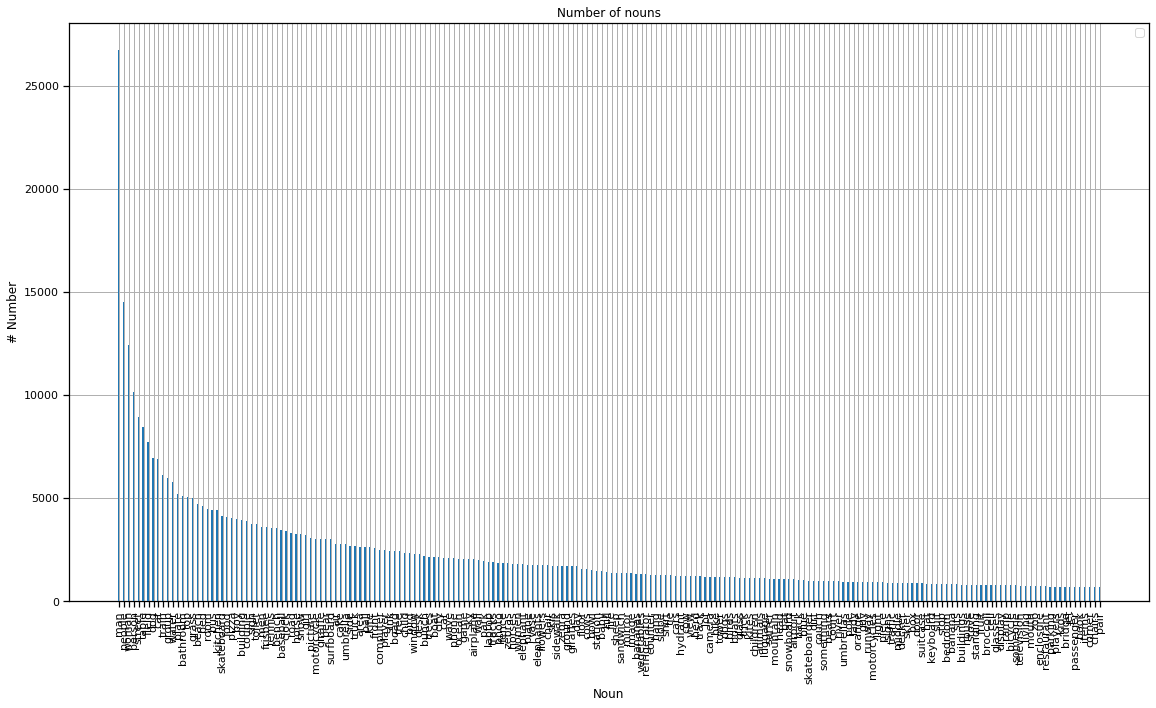

In [24]:
vals = list(noun_distr_per_noun_no[3].values())
keys = list(noun_distr_per_noun_no[3].keys())

sort_idx = list(np.argsort(- np.array(vals)))

x_ticklabel = list(map(keys.__getitem__, sort_idx))[:200]
values = list(map(vals.__getitem__, sort_idx))[:200]

plot_bars(values, x_ticklabel, 'Noun', '# Number', 
          'Number of nouns', rot_angle=90)

In [25]:
values[199]

659

In [26]:
values = sorted(list(vals), reverse=True)
print(len(values))

10003


In [27]:
values[2000:2010]

[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

In [ ]:
# with open('../../data/coco/coco_stats/noun_stats.pkl', 'wb') as f:
#     pickle.dump([noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns], f)

# no_nouns_list, img_caps_list = zip(*(sorted(img_caps_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
# no_nouns_list, img_caps_list = list(no_nouns_list), list(img_caps_list)
# 
# del(no_nouns_list[0])
# del(img_caps_list[0])
# print(no_nouns_list)

# with open('../../data/coco/coco_stats/img_caps_per_noun_list.pkl', 'wb') as f:
#     pickle.dump(img_caps_list, f)

## Getting Verb Stats

In [ ]:
max_verb_no = 3
# verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs = per_tp_no_distr_stats(max_verb_no, 'VB')

# Loading from saved location
with open('../../data/coco_stats/coco/verb_stats.pkl', 'rb') as f:
    verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs = pickle.load(f)

In [ ]:
max_verb_no = 3
verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs = per_tp_no_distr_stats(max_verb_no, 'VB')

In [ ]:
print('Total Examples with {} verbs per example: {}\n\n'.format(0, ex_count_per_verb_no[0]))

for i in range(1,max_verb_no+1):
    print('Total Examples with {} verbs per example: {}'.
          format(i, ex_count_per_verb_no[i]))
    print('Total Unique verbs with {} verbs per example: {}\n'.format(i, len(verb_distr_per_verb_no[i])))
    
print('Total Examples with > {} verbs per example: {}'.format(max_verb_no, ex_count_per_verb_no['Rest']))
print('Total Unique verbs with > {} verbs per example: {}\n'.format(i, len(verb_distr_per_verb_no['Rest'])))

print('Total number of unique verbs: {}'.format(len(net_unique_verbs)))

In [ ]:
# with open('../../data/coco_stats/coco/verb_stats.pkl', 'wb') as f:
#     pickle.dump([verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs], f)

## Getting Noun-Verb statistics

In [ ]:
import itertools

# Counts number of examples for each noun-verb
# for those sentences having number of noun types each of {0,1,2,..max_noun_no,'Rest'}

def per_nv_no_distr_stats(max_noun_no, max_verb_no):
    
    nv_distr_per_nv_no = {}
    ex_count_per_nv_no = {}
    
    for i in list(range(0,max_noun_no+1)) + ['Rest']:
        for j in list(range(0,max_verb_no+1)) + ['Rest']:
            nv_distr_per_nv_no[(i,j)] = {}
            ex_count_per_nv_no[(i,j)] = 0 
        
    net_unique_nvs = set()
    
    def put_words_in_dict(d, ws):
        for w in ws:
            if w not in d:
                d[w] = 1
            else:
                d[w] += 1
    
    for item in coco_train_anno_all['annotations']:
        tokens = tokenizer.tokenize(item['caption'])
        noun_types_per_ex = set()
        verb_types_per_ex = set()
        
        for word, pos in nltk.pos_tag(tokens):
            if 'NN' in pos:
                noun_types_per_ex.add(word)
            elif 'VB' in pos:
                verb_types_per_ex.add(word)               
                
        no_noun_types_per_ex = len(noun_types_per_ex)
        no_verb_types_per_ex = len(verb_types_per_ex)
        no_nv_types_per_ex = (no_noun_types_per_ex, no_verb_types_per_ex)
        if no_noun_types_per_ex > 0 and no_verb_types_per_ex > 0:
            nv_types_per_ex = list(itertools.product(noun_types_per_ex, verb_types_per_ex))
        
        if no_nv_types_per_ex == (0,0):
            ex_count_per_nv_no[(0,0)] += 1
            continue
            
        elif no_noun_types_per_ex == 0:
            idx2 = no_verb_types_per_ex if no_verb_types_per_ex <= max_verb_no else 'Rest'
            d_to_fill = nv_distr_per_nv_no[(0, idx2)]
            v_to_fill = verb_types_per_ex
            ex_count_per_nv_no[(0, idx2)] += 1       
            
        elif no_verb_types_per_ex == 0:
            idx1 = no_noun_types_per_ex if no_noun_types_per_ex <= max_noun_no else 'Rest'
            d_to_fill = nv_distr_per_nv_no[(idx1, 0)]
            v_to_fill = noun_types_per_ex
            ex_count_per_nv_no[(idx1, 0)] += 1                  
            
        elif no_noun_types_per_ex <= max_noun_no and no_verb_types_per_ex <= max_verb_no:
            d_to_fill = nv_distr_per_nv_no[(no_noun_types_per_ex, no_verb_types_per_ex)]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[(no_noun_types_per_ex, no_verb_types_per_ex)] += 1
            
        elif no_noun_types_per_ex > max_noun_no and no_verb_types_per_ex > max_verb_no:
            d_to_fill = nv_distr_per_nv_no[('Rest', 'Rest')]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[('Rest', 'Rest')] += 1
            
        elif no_noun_types_per_ex > max_noun_no:
            d_to_fill = nv_distr_per_nv_no[('Rest', no_verb_types_per_ex)]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[('Rest', no_verb_types_per_ex)] += 1
            
        else:
            d_to_fill = nv_distr_per_nv_no[(no_noun_types_per_ex, 'Rest')]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[(no_noun_types_per_ex, 'Rest')] += 1
        
        put_words_in_dict(d_to_fill, v_to_fill)
                
    return nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs

In [ ]:
max_nv_no = 3
# nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs = per_nv_no_distr_stats(max_nv_nv, max_nv_nv)

# Loading from saved location
with open('../../data/coco_stats/coco/noun_verb_stats.pkl', 'rb') as f:
    nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs = pickle.load(f)

In [ ]:
# with open('../../data/coco_stats/coco/noun_verb_stats.pkl', 'wb') as f:
#     pickle.dump([nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs], f)